# Question 1

The correlation coefficient p_ij , defined as the Pearson correlation between log-normalized returns, is bounded between −1 and 1. These bounds reflect the strength and direction of linear relationships between the time series of two stocks.

* p_ij = 1 -> perfect postive correlation (stocks move in sync)
* p_ij = -1 -> perfect negative correlation (stocks move oppositely)
* p_ij = 0 -> no linear correlation

Log-normalized returns  r_i(t) = log(1 + q_i(t))  are preferred over simple returns for several reasons:

1. Additivity: Log-returns can be summed across time intervals, enabling consistent aggregation when analyzing weekly or monthly data. This is not possible with simple returns.

2. Statistical Normality: Log-returns tend to be more symmetrically distributed and closer to Gaussian, which improves the reliability of correlation estimates. This is especially important since the Pearson correlation assumes linearity and approximate normality.

3. Scale Invariance: Log-returns normalize price changes, allowing meaningful comparisons across stocks regardless of their price levels — critical when constructing a unified correlation graph.

4. Balanced Interpretation of Gains/Losses: Log-returns treat upward and downward movements more symmetrically than simple returns, avoiding skewed effects and ensuring unbiased measurement of volatility and co-movement.

These advantages make log-normalized returns the appropriate choice for correlation-based graph construction and clustering of stock behaviors over different time scales.

# Question 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Path to the folder with stock CSVs
data_dir = "/content/drive/MyDrive/finance_data/data"

In [3]:
# Helper: compute log returns from Close prices
def get_log_returns(file_path):
    df = pd.read_csv(file_path)
    df = df.sort_values("Date")
    prices = df["Close"].values
    log_returns = np.diff(np.log(prices))
    return log_returns

# List all CSVs
stock_files = glob(os.path.join(data_dir, "*.csv"))
stock_names = [os.path.basename(f).replace(".csv", "") for f in stock_files]

# Get shortest common time series length
min_len = min(len(get_log_returns(f)) for f in stock_files)

# Collect aligned log return series
log_return_list = [get_log_returns(f)[:min_len] for f in stock_files]
log_return_matrix = np.column_stack(log_return_list)
log_return_df = pd.DataFrame(log_return_matrix, columns=stock_names)

In [4]:
# Pearson correlation between columns
cor_matrix = log_return_df.corr().values  # ρ_ij

# Convert to edge weights using: w_ij = sqrt(2(1 - ρ_ij))
weight_matrix = np.sqrt(2 * (1 - cor_matrix))

# Upper triangle only (excluding diagonal as self edges are not meaningful)
upper_tri_indices = np.triu_indices_from(weight_matrix, k=1)
edge_weights = weight_matrix[upper_tri_indices]

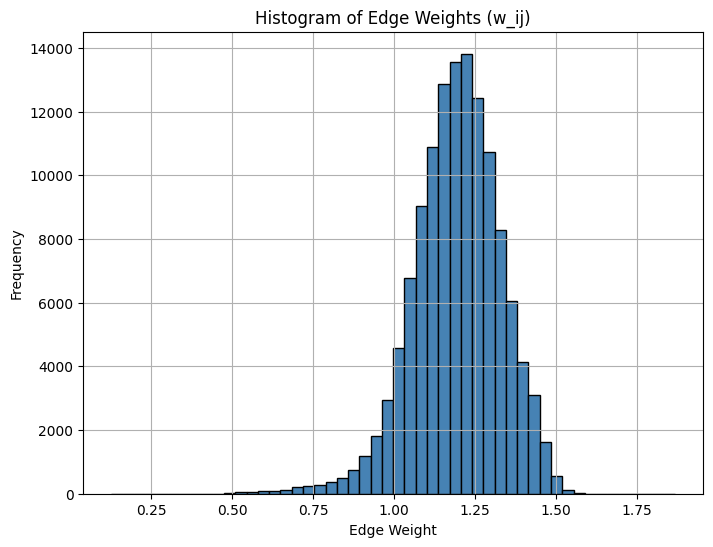

In [ ]:
# Histogram of edge weights
plt.figure(figsize=(8, 6))
plt.hist(edge_weights, bins=50, color="steelblue", edgecolor="black")
plt.title("Histogram of Edge Weights (w_ij)")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram of edge weights w_ij reveals that most stock pairs exhibit moderate positive correlation, with weights peaking around 1.2 (equivalent to  p_ij ≅ 0.3 ).

Very few stock pairs are highly correlated ( w_ij < 0.75 ) or strongly anti-correlated ( w_ij > 1.7 ), suggesting that most stocks move somewhat independently, especially across sectors.

This pattern is consistent with a diversified market where sector-specific or macroeconomic factors induce partial co-movement, while many stocks remain relatively uncorrelated.

# Question 3

In [5]:
# Path to Name_sector.csv
sector_file = "/content/drive/MyDrive/finance_data/Name_sector.csv"

# Load sector mapping
sector_df = pd.read_csv(sector_file)
sector_map = dict(zip(sector_df["Symbol"], sector_df["Sector"]))

In [ ]:
import networkx as nx

# Create undirected graph with edge weights
G = nx.Graph()

# Add nodes with sector as attribute
for stock in stock_names:
    sector = sector_map.get(stock, "Unknown")
    G.add_node(stock, sector=sector)

# Add edges with computed weights
for i in range(len(stock_names)):
    for j in range(i + 1, len(stock_names)):
        G.add_edge(stock_names[i], stock_names[j], weight=weight_matrix[i, j])

# Extract the Minimum Spanning Tree (MST)
mst = nx.minimum_spanning_tree(G, weight='weight')

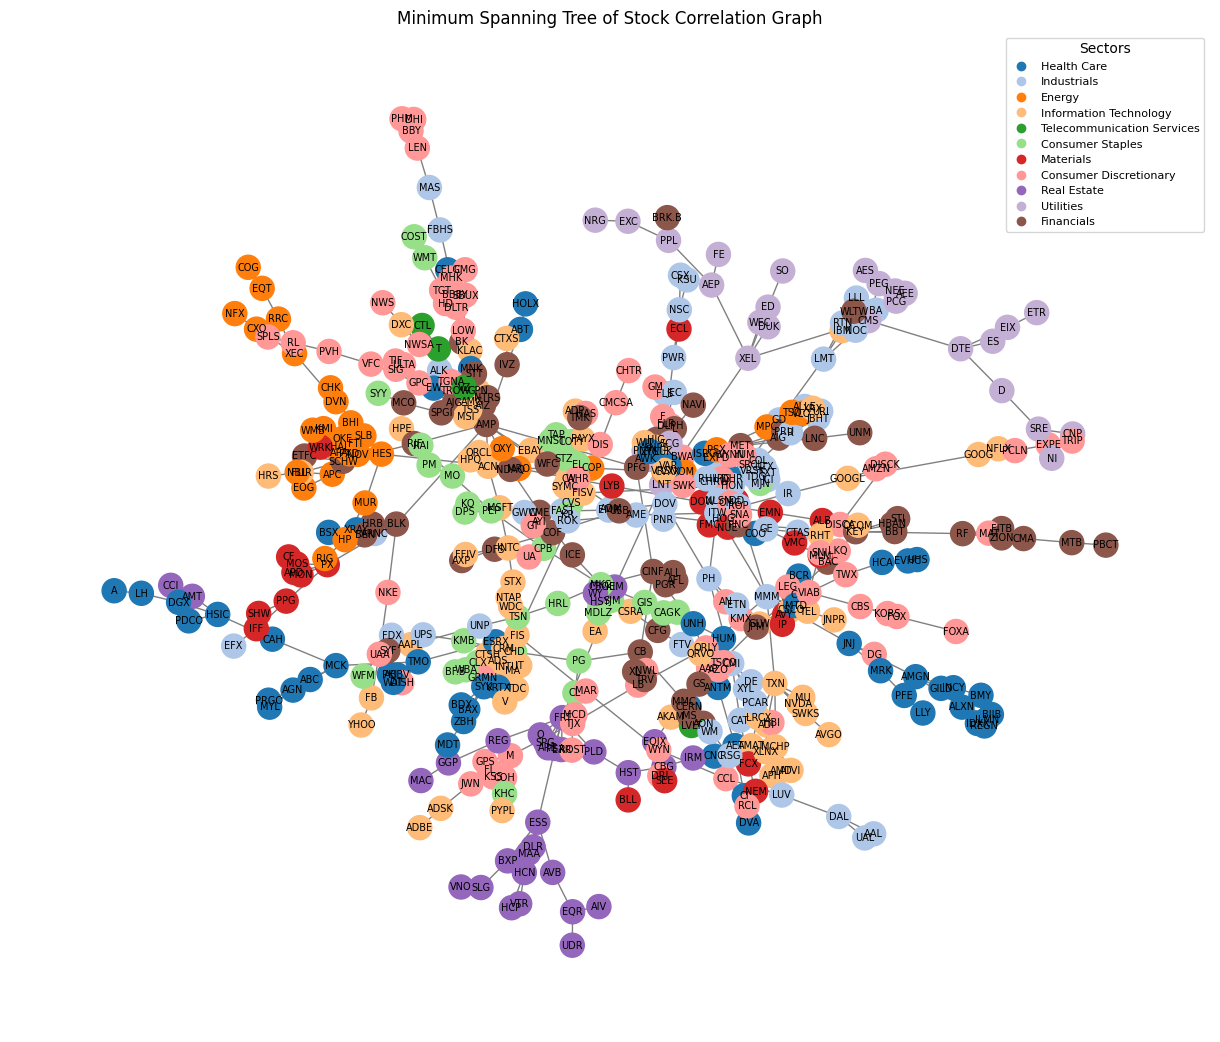

In [ ]:
import matplotlib.pyplot as plt

# Assign unique color per sector
sectors = list(set(nx.get_node_attributes(mst, 'sector').values()))
sector_colors = {sector: plt.cm.tab20(i % 20) for i, sector in enumerate(sectors)}

# Node colors based on sector
node_colors = [sector_colors[mst.nodes[n]['sector']] for n in mst.nodes()]

# Layout for tree (can also try spring_layout or kamada_kawai_layout)
pos = nx.spring_layout(mst, seed=42)

plt.figure(figsize=(12, 10))
nx.draw(mst, pos,
        with_labels=True,
        node_color=node_colors,
        node_size=300,
        edge_color='gray',
        font_size=7)

# Legend
for sec in sector_colors:
    plt.plot([], [], color=sector_colors[sec], marker='o', linestyle='', label=sec)
plt.legend(loc='best', fontsize=8, title="Sectors")
plt.title("Minimum Spanning Tree of Stock Correlation Graph")
plt.axis('off')
plt.show()

The Minimum Spanning Tree (MST) was constructed from the stock correlation graph using edge weights defined by  w_ij, where p_ij represents the Pearson correlation between log-normalized daily returns of stocks  i  and  j . Sector labels from Name_sector.csv were used to assign each stock to its respective market sector, and nodes were color-coded accordingly.

Observed Patterns in the MST:

1. Vine Clusters (Intra-sector grouping): Stocks from the same sector tend to form tightly connected linear or branched structures. Notably, sectors such as Energy and Health Care exhibit strong internal clustering, indicating high intra-sector correlation.

2. Peripheral Positioning of Certain Sectors: Sectors including Utilities and Real Estate are positioned on the outer branches of the MST, suggesting lower correlation with the broader market and minimal inter-sector connectivity.

3. Central Bridging Nodes: Stocks from sectors such as Financials and Information Technology often appear in central positions within the MST, acting as bridges between different sector clusters. This placement reflects moderate correlation with a wide range of sectors, consistent with their systemic economic influence.

These structural patterns reflect meaningful economic relationships. The MST effectively reduces the full correlation graph to a simplified backbone that highlights sectoral cohesion and cross-sector linkages, offering insight into the underlying topology of stock return behavior. The MST reveals clear vine-like clusters where stocks within the same sector form tightly connected branches. Notably, sectors such as Financials and Energy appear as distinct chains, while sectors like Technology act as bridges, connecting multiple groups. This structure reflects stronger intra-sector correlation and limited inter-sector dependencies.


# Question 4

In [ ]:
!pip install python-louvain

import community as community_louvain
import networkx as nx

# Run Louvain community detection (alternative for walktrap in python)
partition = community_louvain.best_partition(mst)  # returns dict: node -> community_id

# Assign community as node attribute
nx.set_node_attributes(mst, partition, "community")

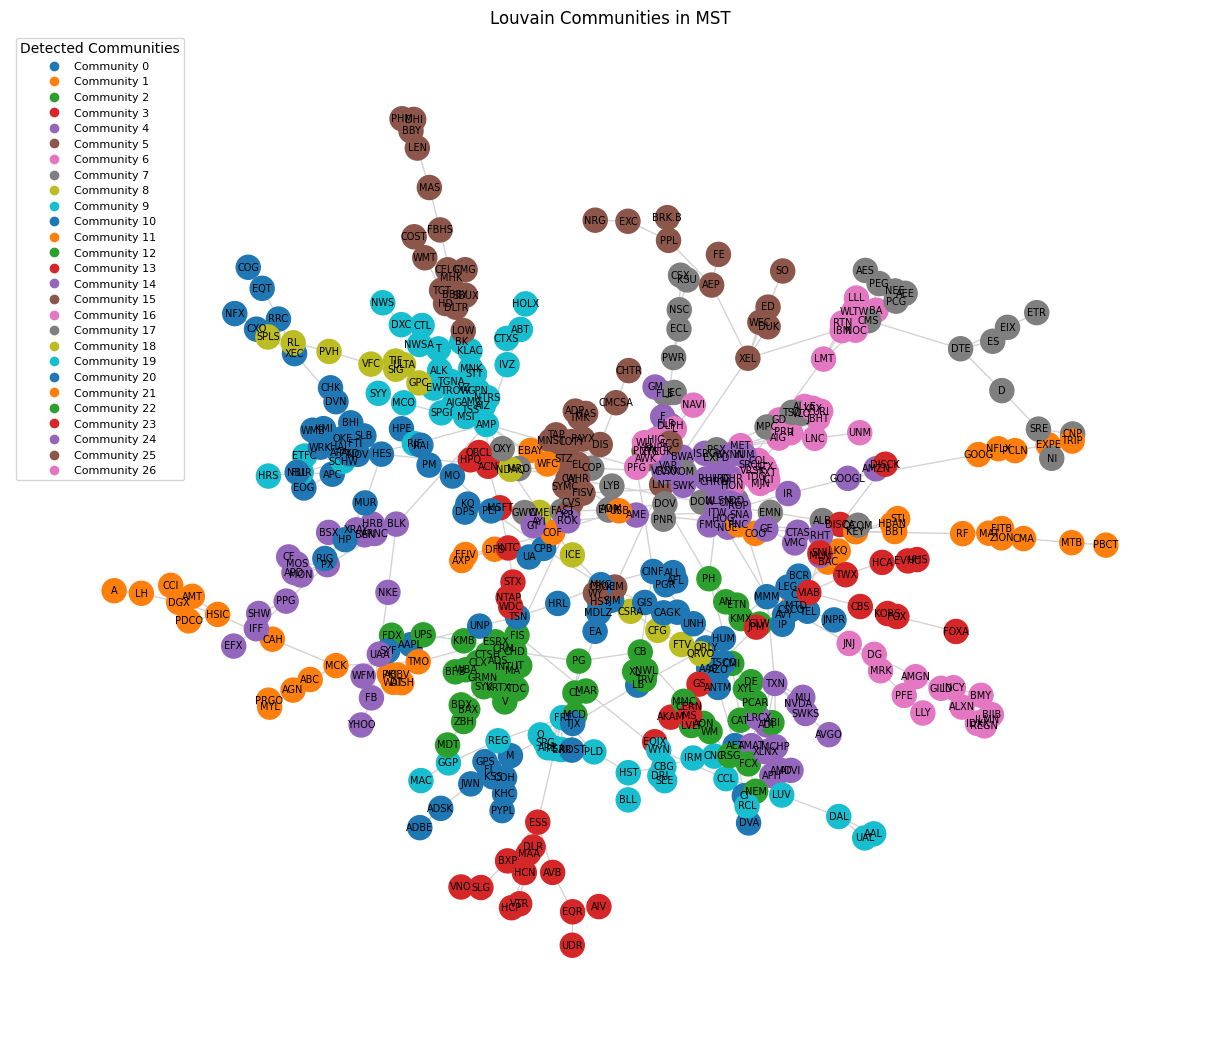

In [ ]:
import matplotlib.pyplot as plt

# Generate color map for communities
communities = list(set(partition.values()))
community_colors = {cid: plt.cm.tab10(i % 10) for i, cid in enumerate(communities)}
node_colors = [community_colors[partition[n]] for n in mst.nodes()]

# Position using spring layout
pos = nx.spring_layout(mst, seed=42)

plt.figure(figsize=(12, 10))
nx.draw(mst, pos,
        node_color=node_colors,
        with_labels=True,
        node_size=300,
        font_size=7,
        edge_color='lightgray')

# Legend
for cid in communities:
    plt.plot([], [], color=community_colors[cid], marker='o', linestyle='', label=f"Community {cid}")
plt.legend(loc="best", fontsize=8, title="Detected Communities")
plt.title("Louvain Communities in MST")
plt.axis("off")
plt.show()

In [ ]:
from sklearn.metrics import homogeneity_score, completeness_score

# True labels: sector of each stock
true_labels = [mst.nodes[n]['sector'] for n in mst.nodes()]
# Predicted labels: community id
pred_labels = [partition[n] for n in mst.nodes()]

h_score = homogeneity_score(true_labels, pred_labels)
c_score = completeness_score(true_labels, pred_labels)

print(f"Homogeneity: {h_score:.4f}")
print(f"Completeness: {c_score:.4f}")

Homogeneity: 0.5709
Completeness: 0.4004


Louvain community detection was applied to the MST of the stock correlation graph, resulting in 27 communities. The detected clusters were compared against sector labels using two metrics:
* Homogeneity: 0.5709
* Completeness: 0.4004

The moderate homogeneity indicates that many communities contain mostly one sector, but some mixing exists. The lower completeness suggests that several sectors are split across multiple communities. This outcome is expected, given that the MST simplifies the full correlation graph and captures only the strongest connections, limiting its ability to preserve full sector grouping. While the Louvain communities partially align with sectors, overlapping correlations and MST sparsity reduce the clarity of separation. Sectors with cross-industry dependencies (e.g., large diversified companies) contribute to mixed community composition, explaining imperfect homogeneity and completeness.

# Question 5

In [ ]:
# Actual α (Neighborhood Purity)

nodes = list(mst.nodes())
sectors = nx.get_node_attributes(mst, "sector")

correct_ratios = []

for node in nodes:
    neighbors = list(mst.neighbors(node))
    if not neighbors:
        continue
    node_sector = sectors[node]
    same_sector_count = sum(sectors[n] == node_sector for n in neighbors)
    ratio = same_sector_count / len(neighbors)
    correct_ratios.append(ratio)

alpha_actual = np.mean(correct_ratios)
print(f"Actual α: {alpha_actual:.4f}")

Actual α: 0.7432


In [ ]:
# Baseline α (Sector Frequency Probability)

from collections import Counter

sector_counts = Counter(sectors.values())
total_nodes = len(nodes)

baseline_ratios = [
    sector_counts[sectors[node]] / total_nodes
    for node in nodes
]

alpha_baseline = np.mean(baseline_ratios)
print(f"Baseline α: {alpha_baseline:.4f}")


Baseline α: 0.1146


To assess how well the MST structure reflects sectoral grouping, a sector prediction score was computed based on the proportion of each stock’s neighbors that belong to the same sector. This actual score was compared to a baseline that assumes sector prediction by random chance, based only on overall sector frequencies.

The results show:
* Actual α = 0.7432
* nBaseline α = 0.1146

The high actual score indicates that, on average, a stock is surrounded by neighbors from the same sector more than 74% of the time. In contrast, the baseline score suggests that random guessing would only be correct about 11% of the time. This large gap demonstrates that the MST structure strongly preserves sectoral relationships, and that local connectivity in the graph is a meaningful indicator of sector membership.

# Question 6

In [7]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from glob import glob

# Load sector mapping
sector_df = pd.read_csv("/content/drive/MyDrive/finance_data/Name_sector.csv")
sector_map = dict(zip(sector_df["Symbol"], sector_df["Sector"]))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# weekly log returns
data_dir = "/content/drive/MyDrive/finance_data/data"
stock_files = glob(os.path.join(data_dir, "*.csv"))
stock_names = [os.path.basename(f).replace(".csv", "") for f in stock_files]

def get_weekly_log_returns(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df[df["Date"].dt.dayofweek == 0]  # Mondays only
    df = df.sort_values("Date")
    prices = df["Close"].values
    log_returns = np.diff(np.log(prices))
    return log_returns

# Align lengths
min_len = min(len(get_weekly_log_returns(f)) for f in stock_files)
log_returns_list = [get_weekly_log_returns(f)[:min_len] for f in stock_files]
log_return_matrix = np.column_stack(log_returns_list)
log_return_df = pd.DataFrame(log_return_matrix, columns=stock_names)

#Warnings are due to different date formats in the csv files

<ipython-input-12-2231013aa30f>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])
<ipython-input-12-2231013aa30f>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])
<ipython-input-12-2231013aa30f>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])
<ipython-input-12-2231013aa30f>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format

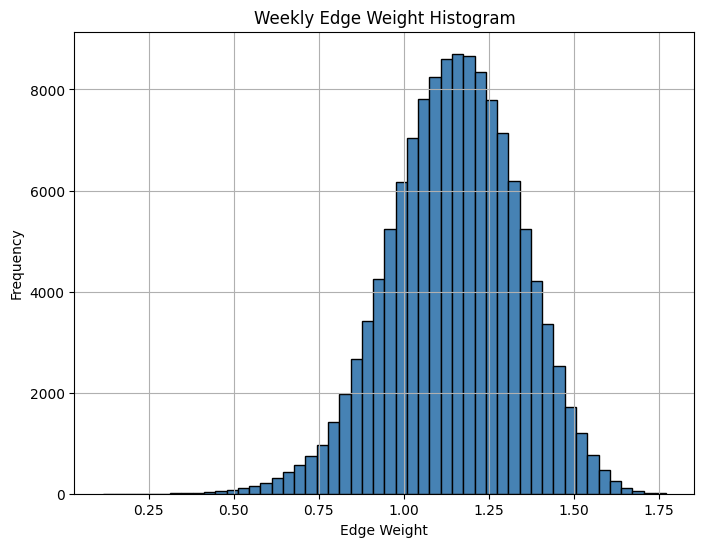

In [13]:
#Q2
import matplotlib.pyplot as plt

# Correlation and weights
cor_matrix = log_return_df.corr().values
weight_matrix = np.sqrt(2 * (1 - cor_matrix))

# Upper triangle
upper_tri = np.triu_indices_from(weight_matrix, k=1)
edge_weights = weight_matrix[upper_tri]

# Plot
plt.figure(figsize=(8, 6))
plt.hist(edge_weights, bins=50, color="steelblue", edgecolor="black")
plt.title("Weekly Edge Weight Histogram")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram of edge weights from the weekly correlation graph shows a bell-shaped distribution, peaking around 1.2, similar to the daily data but with slightly narrower spread. This reflects reduced short-term noise in weekly returns, resulting in more stable but slightly weaker correlations between stocks. The distribution confirms that most stock pairs exhibit moderate dissimilarity under weekly sampling.

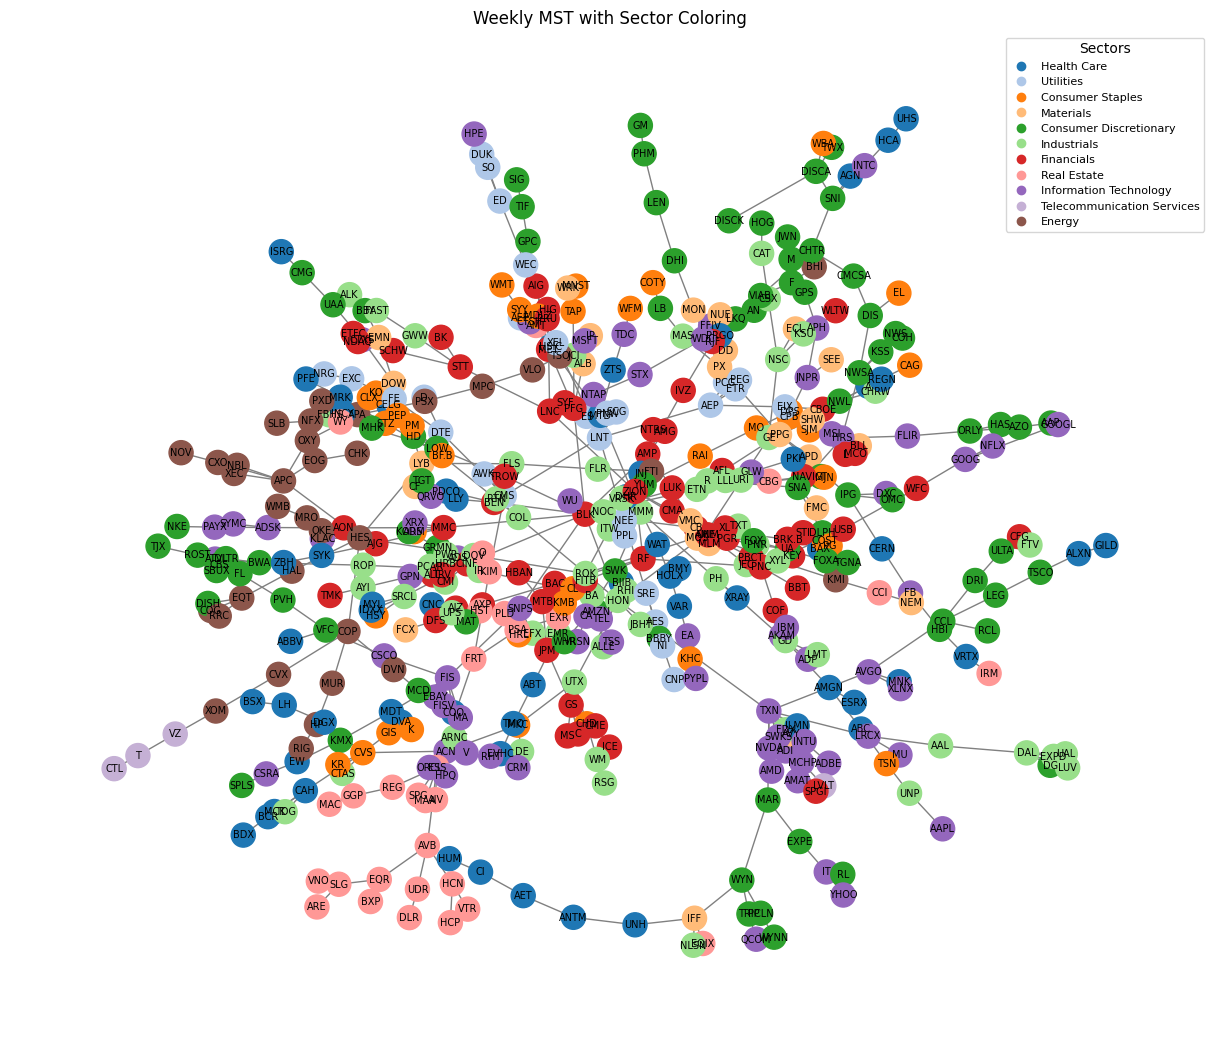

In [14]:
#Q3
import networkx as nx

# Build full graph
G = nx.Graph()
for stock in stock_names:
    sector = sector_map.get(stock, "Unknown")
    G.add_node(stock, sector=sector)

for i in range(len(stock_names)):
    for j in range(i + 1, len(stock_names)):
        G.add_edge(stock_names[i], stock_names[j], weight=weight_matrix[i, j])

mst = nx.minimum_spanning_tree(G, weight='weight')

# Draw MST with sector colors
sectors = list(set(sector_map.values()))
color_map = {s: plt.cm.tab20(i % 20) for i, s in enumerate(sectors)}
node_colors = [color_map[mst.nodes[n]["sector"]] for n in mst.nodes]

pos = nx.spring_layout(mst, seed=42)
plt.figure(figsize=(12, 10))
nx.draw(mst, pos,
        node_color=node_colors,
        with_labels=True,
        node_size=300,
        font_size=7,
        edge_color='gray')

# Add legend
for s in color_map:
    plt.plot([], [], marker='o', color=color_map[s], label=s, linestyle='')
plt.legend(fontsize=8, title="Sectors")
plt.title("Weekly MST with Sector Coloring")
plt.axis("off")
plt.show()

The MST constructed from weekly log returns maintains a clear sectoral structure, with many vine-like clusters of same-sector stocks, particularly in Financials, Health Care, and Industrials. While the structure is overall coherent, some sectors appear more fragmented or less centralized compared to the daily MST, likely due to the smoothing effect of weekly data that mutes short-term co-movements.

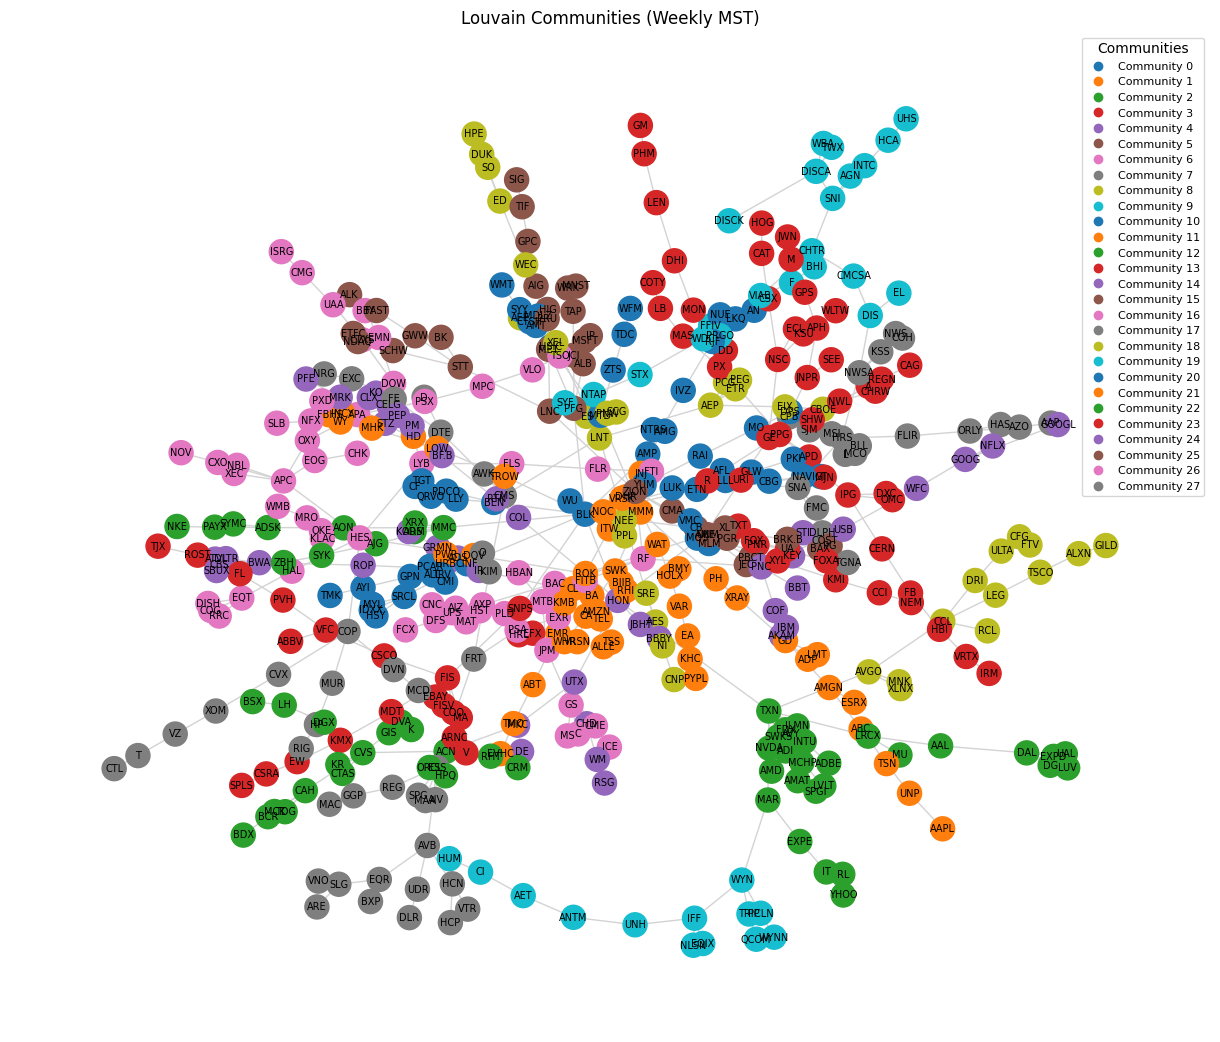

Homogeneity: 0.4431
Completeness: 0.3058


In [15]:
# Q4
!pip install python-louvain
import community as community_louvain
from sklearn.metrics import homogeneity_score, completeness_score

# Louvain partition
partition = community_louvain.best_partition(mst)
nx.set_node_attributes(mst, partition, "community")

# Draw with community colors
communities = list(set(partition.values()))
community_colors = {cid: plt.cm.tab10(i % 10) for i, cid in enumerate(communities)}
node_colors = [community_colors[partition[n]] for n in mst.nodes]

plt.figure(figsize=(12, 10))
nx.draw(mst, pos,
        node_color=node_colors,
        with_labels=True,
        node_size=300,
        font_size=7,
        edge_color='lightgray')

for cid in communities:
    plt.plot([], [], color=community_colors[cid], marker='o', linestyle='', label=f"Community {cid}")
plt.legend(fontsize=8, title="Communities")
plt.title("Louvain Communities (Weekly MST)")
plt.axis("off")
plt.show()

# Compute homogeneity and completeness
true_labels = [mst.nodes[n]['sector'] for n in mst.nodes]
pred_labels = [partition[n] for n in mst.nodes]
h = homogeneity_score(true_labels, pred_labels)
c = completeness_score(true_labels, pred_labels)
print(f"Homogeneity: {h:.4f}")
print(f"Completeness: {c:.4f}")

Louvain community detection on the weekly MST resulted in 28 communities with a homogeneity score of 0.4431 and a completeness score of 0.3058. These are slightly lower than in the daily case, suggesting that weekly sampling weakens sector distinction and increases intermixing across communities. Nonetheless, there is still moderate alignment between the detected communities and sector labels.

In [16]:
# Q5
from collections import Counter

# Actual α
correct_ratios = []
for node in mst.nodes():
    neighbors = list(mst.neighbors(node))
    if not neighbors:
        continue
    sector = mst.nodes[node]["sector"]
    same_sector_count = sum(mst.nodes[n]["sector"] == sector for n in neighbors)
    correct_ratios.append(same_sector_count / len(neighbors))

alpha_actual = np.mean(correct_ratios)

# Baseline α
sector_counts = Counter([mst.nodes[n]['sector'] for n in mst.nodes()])
total_nodes = len(mst.nodes())
baseline_ratios = [sector_counts[mst.nodes[n]['sector']] / total_nodes for n in mst.nodes()]
alpha_baseline = np.mean(baseline_ratios)

print(f"Actual α: {alpha_actual:.4f}")
print(f"Baseline α: {alpha_baseline:.4f}")

Actual α: 0.5911
Baseline α: 0.1146


The sector prediction score based on neighborhood purity in the MST yielded an actual α of 0.5911, well above the baseline α of 0.1146. This indicates that stocks still tend to be surrounded by others from the same sector even with weekly sampling, though the purity is somewhat reduced compared to daily returns. The MST retains meaningful local sector structure at the weekly level.

# Question 7

In [22]:
# monthly log returns
def get_15th_monthly_log_returns(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date")

    # Extract rows with calendar day == 15
    df_15 = df[df["Date"].dt.day == 15].copy()

    # Convert to monthly period for alignment
    df_15["Month"] = df_15["Date"].dt.to_period("M")

    # Ensure one 15th entry per month
    df_15 = df_15.groupby("Month").first().reset_index()

    prices = df_15["Close"].values
    log_returns = np.diff(np.log(prices))
    return log_returns

min_len = min(len(get_15th_monthly_log_returns(f)) for f in stock_files)
log_return_list = [get_15th_monthly_log_returns(f)[:min_len] for f in stock_files]
log_return_matrix = np.column_stack(log_return_list)
log_return_df = pd.DataFrame(log_return_matrix, columns=stock_names)

<ipython-input-22-3145092855e9>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])
<ipython-input-22-3145092855e9>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])
<ipython-input-22-3145092855e9>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])
<ipython-input-22-3145092855e9>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format

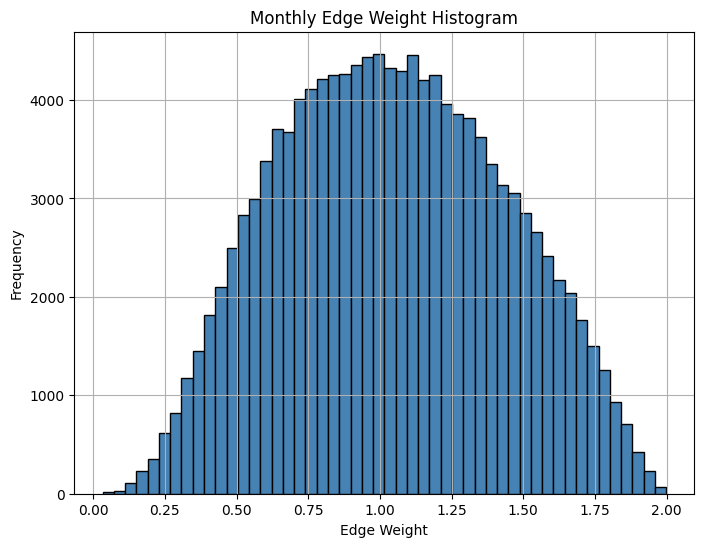

In [23]:
# Q2

import matplotlib.pyplot as plt

cor_matrix = log_return_df.corr().values
weight_matrix = np.sqrt(2 * (1 - cor_matrix))

# Get upper triangle weights
upper_tri = np.triu_indices_from(weight_matrix, k=1)
edge_weights = weight_matrix[upper_tri]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(edge_weights, bins=50, color='steelblue', edgecolor='black')
plt.title("Monthly Edge Weight Histogram")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The edge weight histogram computed from log returns sampled on the 15th of each month shows a symmetric, bell-shaped distribution centered around 1.0. Compared to earlier timeframes, the histogram appears slightly broader and flatter, indicating weaker and more variable correlations between stocks. This broader dispersion reflects the impact of using sparse monthly data, which increases noise and weakens short-term alignment between stock movements.

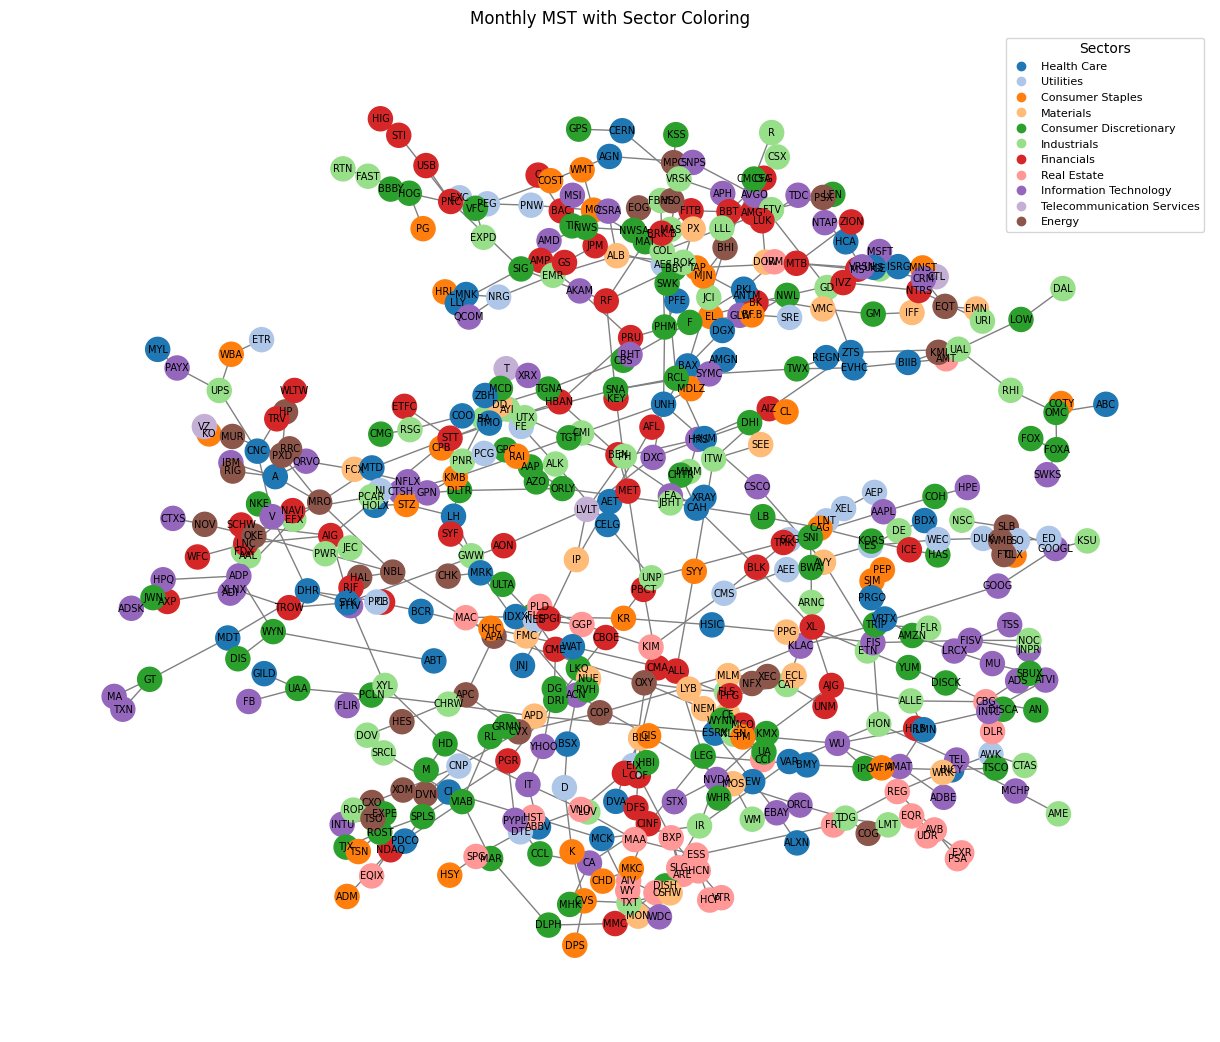

In [24]:
#Q3

import networkx as nx

# Build graph
G = nx.Graph()
for stock in stock_names:
    sector = sector_map.get(stock, "Unknown")
    G.add_node(stock, sector=sector)

for i in range(len(stock_names)):
    for j in range(i + 1, len(stock_names)):
        G.add_edge(stock_names[i], stock_names[j], weight=weight_matrix[i, j])

# Extract MST
mst = nx.minimum_spanning_tree(G, weight='weight')

# Layout and color
sectors = list(set(sector_map.values()))
color_map = {s: plt.cm.tab20(i % 20) for i, s in enumerate(sectors)}
node_colors = [color_map[mst.nodes[n]["sector"]] for n in mst.nodes]

pos = nx.spring_layout(mst, seed=42)
plt.figure(figsize=(12, 10))
nx.draw(mst, pos,
        node_color=node_colors,
        with_labels=True,
        node_size=300,
        font_size=7,
        edge_color='gray')

for s in color_map:
    plt.plot([], [], marker='o', color=color_map[s], label=s, linestyle='')
plt.legend(fontsize=8, title="Sectors")
plt.title("Monthly MST with Sector Coloring")
plt.axis("off")
plt.show()

The MST generated from monthly returns sampled on the 15th maintains weak but visible sector clusters, particularly in sectors like Financials and Industrials. However, the overall graph appears more fragmented and less vine-like compared to daily or weekly MSTs. Sector groups are less cohesive, and cross-sector connections are more common, illustrating how the reduced temporal resolution limits the fidelity of sectoral co-movement patterns.

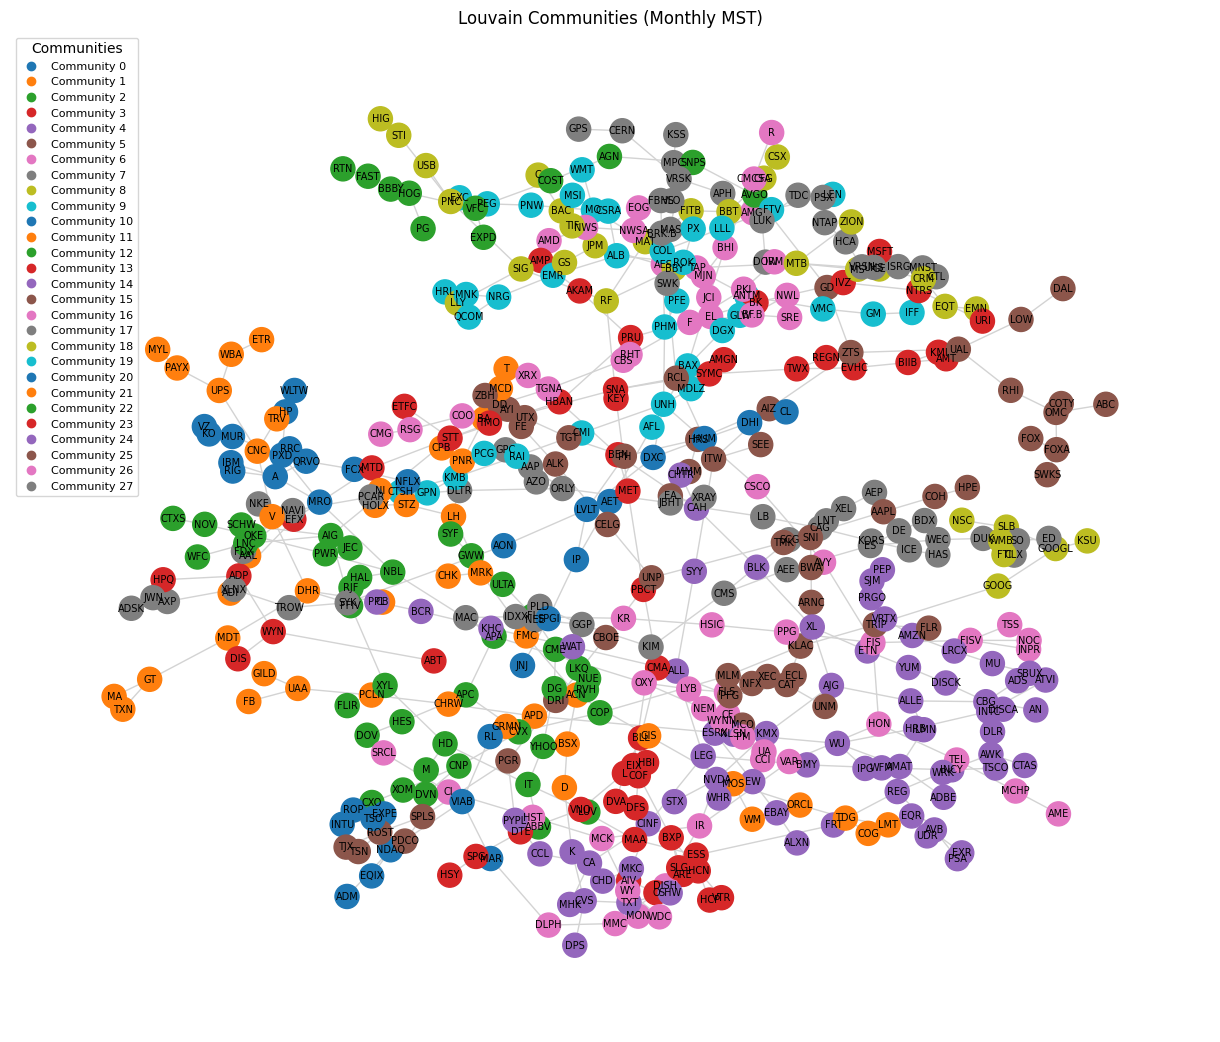

Homogeneity: 0.2893
Completeness: 0.1994


In [25]:
#Q4

import community as community_louvain
from sklearn.metrics import homogeneity_score, completeness_score

partition = community_louvain.best_partition(mst)
nx.set_node_attributes(mst, partition, "community")

# Draw community graph
communities = list(set(partition.values()))
comm_colors = {cid: plt.cm.tab10(i % 10) for i, cid in enumerate(communities)}
node_colors = [comm_colors[partition[n]] for n in mst.nodes]

plt.figure(figsize=(12, 10))
nx.draw(mst, pos,
        node_color=node_colors,
        with_labels=True,
        node_size=300,
        font_size=7,
        edge_color='lightgray')

for cid in communities:
    plt.plot([], [], color=comm_colors[cid], marker='o', linestyle='', label=f"Community {cid}")
plt.legend(fontsize=8, title="Communities")
plt.title("Louvain Communities (Monthly MST)")
plt.axis("off")
plt.show()

# Compute homogeneity and completeness
true_labels = [mst.nodes[n]['sector'] for n in mst.nodes]
pred_labels = [partition[n] for n in mst.nodes]
h = homogeneity_score(true_labels, pred_labels)
c = completeness_score(true_labels, pred_labels)
print(f"Homogeneity: {h:.4f}")
print(f"Completeness: {c:.4f}")

Louvain community detection on the 15th-based MST resulted in a homogeneity score of 0.2893 and a completeness score of 0.1994 — the lowest across all timeframes. These results indicate that the communities are both internally diverse and fail to capture full sectors, reflecting high structural noise and limited community coherence when using infrequent return sampling. This degradation aligns with expectations for sparse monthly data.

In [26]:
# Q5
from collections import Counter

# Actual α
correct_ratios = []
for node in mst.nodes():
    neighbors = list(mst.neighbors(node))
    if not neighbors:
        continue
    sector = mst.nodes[node]["sector"]
    same_sector_count = sum(mst.nodes[n]["sector"] == sector for n in neighbors)
    correct_ratios.append(same_sector_count / len(neighbors))

alpha_actual = np.mean(correct_ratios)

# Baseline α
sector_counts = Counter([mst.nodes[n]['sector'] for n in mst.nodes()])
total_nodes = len(mst.nodes())
baseline_ratios = [sector_counts[mst.nodes[n]['sector']] / total_nodes for n in mst.nodes()]
alpha_baseline = np.mean(baseline_ratios)

print(f"Actual α: {alpha_actual:.4f}")
print(f"Baseline α: {alpha_baseline:.4f}")

Actual α: 0.2814
Baseline α: 0.1146


The neighborhood-based sector prediction score (α) dropped to 0.2814, compared to a baseline of 0.1146. While still above random chance, this marks the weakest predictive performance across all sampling strategies. The reduced α confirms that local sector homogeneity deteriorates when monthly data is limited to the 15th, underscoring the trade-off between sampling sparsity and the graph’s structural interpretability.

# Question 8

Analyzing the correlation graphs across daily, weekly, and monthly (15th) sampling reveals several consistent trends and meaningful shifts in network structure and predictability. As granularity decreases from daily to monthly, both the strength and sharpness of stock correlations decline, resulting in broader edge weight distributions and progressively more fragmented MSTs. This is evident from the histograms: daily and weekly data yield tighter edge weight distributions, while monthly sampling shows a wider spread, indicating weaker and more inconsistent relationships between stocks.

In terms of structural organization, the Minimum Spanning Tree (MST) becomes less vine-like and sector-coherent as the sampling interval increases. Daily MSTs display clear sectoral branches with minimal cross-sector connections. Weekly MSTs retain general sectoral structure but with more intermixing. Monthly MSTs, especially those sampled strictly on the 15th, are visibly less structured, with significant sector fragmentation and many isolated or loosely connected nodes.

Community detection further supports this trend: homogeneity and completeness scores decrease steadily from daily (0.5709, 0.4004) to weekly (0.4431, 0.3058), and drop sharply for monthly (0.2893, 0.1994). This suggests that as sampling becomes sparser, communities become both more internally mixed and less aligned with actual sector divisions. The α score, which measures local sector purity, also follows this pattern: daily α = 0.7432, weekly α = 0.5911, and monthly α = 0.2814 — with daily data offering by far the best sector predictability.

Despite these differences, one trend remains consistent: in all cases, the actual α score is substantially higher than the baseline  α score, indicating that local structure within the MST is informative for sector prediction across all time scales — just to varying degrees of strength.

Overall, daily granularity yields the best results for predicting the sector of an unknown stock. This is because it preserves more complete co-movement information, reduces temporal noise through higher-frequency sampling, and enables sharper sectoral clustering both locally and globally. Weekly data offers a balanced trade-off between resolution and noise reduction but still suffers some loss of detail. Monthly sampling — especially limited to the 15th — is too sparse to reliably capture sector structure, resulting in poor community coherence and low neighborhood purity.

# Question 9

# Question 10

# Question 11

# Question 12

# Question 13

# Question 14

# Question 15

# Question 16

# Question 17

# Question 18

# Question 19

# Question 20

# Question 21

# Question 22

# Question 23

# Question 24

# Define your task